In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data

In [3]:
data_path = 'data'

In [4]:
df_train = pd.read_csv(data_path + '/train.csv', index_col="id")
df_test = pd.read_csv(data_path + '/test.csv', index_col="id")
df_test_ans = pd.read_csv(data_path + "/ans.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']
df_pred_sgp4 = pd.read_csv(data_path + "/pred_sgp.csv", index_col="id")

n_sat = len(pd.unique(df_train["sat_id"]))

In [5]:
adv_data = pd.read_csv('/Users/denissurin/Diplom/data/KSD_RP.csv')

In [8]:
df_train.shape

(335147, 14)

# Metrics

In [5]:
from metrics import smape_idao, idao_score, smape_new_vector_norm, mahalanobis_distance

def print_metrics(model_name, pred):
    print(f"\n{model_name}\n")
    print(f"IDAO score:  {idao_score(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE IDAO:  {smape_idao(pred[target_cols], df_test_ans[target_cols])}")    
    print(f"SMAPE new:   {smape_new_vector_norm(pred, df_test_ans)}")

# LR

In [6]:
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm

In [7]:
MODELS = {'LR': LinearRegression(normalize=True), 'L2': Ridge(normalize=True), 'L1': Lasso()}
TRANSFORMERS = {'No transforms': None, 'Poly': PolynomialFeatures(2)}

In [8]:
# features columns 
feature_cols = ["x_sim", "y_sim", "z_sim", "Vx_sim", "Vy_sim", "Vz_sim"]

# target variables columns 
target_cols = ["x", "y", "z", "Vx", "Vy", "Vz"]

In [9]:
# Linear (Polynomial) Regression models
def predict_lr(model, transformer=None):
    X_train = df_train[feature_cols].values
    y_train = df_train[target_cols].values
    X_test = df_test[feature_cols].values
    pred = pd.DataFrame(columns=target_cols, index=df_test.index)
    pred["sat_id"] = df_test["sat_id"]
    n_sat = len(df_train['sat_id'].unique())
    if transformer:
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.fit_transform(X_test)
    
    for sat_id in range(n_sat): 
        mask_train = df_train.sat_id == sat_id
        mask_test = df_test.sat_id == sat_id
        model.fit(X_train[mask_train], y_train[mask_train]) 
        pred.loc[mask_test, target_cols] = model.predict(X_test[mask_test])
    return pred

In [10]:
from itertools import product

for model, transformer in product(MODELS, TRANSFORMERS):
    pred = predict_lr(MODELS[model], TRANSFORMERS[transformer])
    print_metrics(f'{model} {transformer}', pred)


LR No transforms

IDAO score:  91.81678353872567
SMAPE IDAO:  0.08183216461274333
SMAPE new:   0.1272771961005083

LR Poly

IDAO score:  94.43558420612257
SMAPE IDAO:  0.05564415793877425
SMAPE new:   0.11643354874987599

L2 No transforms

IDAO score:  77.37663968452705
SMAPE IDAO:  0.22623360315472948
SMAPE new:   0.35926468707137

L2 Poly

IDAO score:  81.40162944181164
SMAPE IDAO:  0.18598370558188354
SMAPE new:   0.2882618873312472

L1 No transforms

IDAO score:  84.71356577083694
SMAPE IDAO:  0.15286434229163057
SMAPE new:   0.2321950299775657

L1 Poly

IDAO score:  89.01646897175385
SMAPE IDAO:  0.10983531028246145
SMAPE new:   0.1493868550128499


In [11]:
print_metrics("SGP4", df_pred_sgp4)


SGP4

IDAO score:  85.76745399276147
SMAPE IDAO:  0.14232546007238525
SMAPE new:   0.2105207081354428


In [94]:
df_train = pd.read_csv('/Users/denissurin/Diplom/data 2/train_LPC_RP.csv', index_col="id")
df_test = pd.read_csv('/Users/denissurin/Diplom/data 2/test_LPC_RP.csv', index_col="id")
df_test_ans = pd.read_csv("/Users/denissurin/Diplom/data 2/ans_LPC_RP.csv", index_col="id")
df_test_ans['sat_id'] = df_test['sat_id']

In [56]:
from itertools import product
preds=[]
for model, transformer in product(MODELS, TRANSFORMERS):
    pred = predict_lr(MODELS[model], TRANSFORMERS[transformer])
    preds.append(pred)
    #print_metrics(f'{model} {transformer}', pred)

Text(0, 0.5, 'Absolute error')

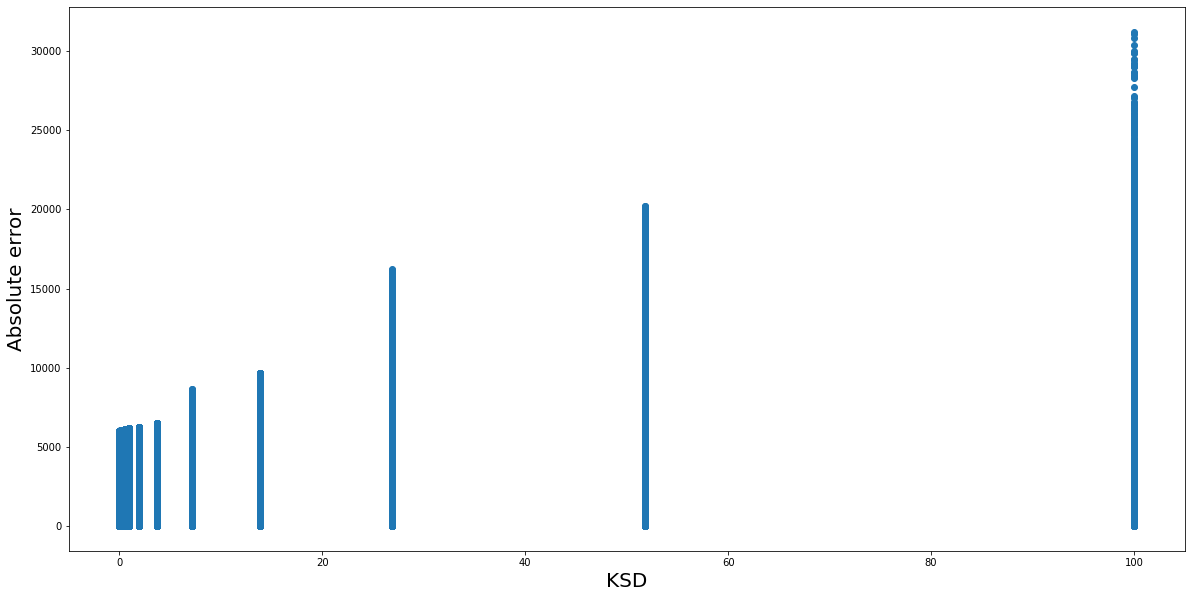

In [87]:
fig, ax = plt.subplots(figsize=(20, 10))
err = np.mean(np.abs(preds[1][target_cols] - df_test_ans[target_cols]), axis=1)
ax.scatter(df['KSD'], err)
plt.xlabel("KSD", fontsize= 20)
plt.ylabel("Absolute error", fontsize= 20)

Text(0, 0.5, 'Absolute error')

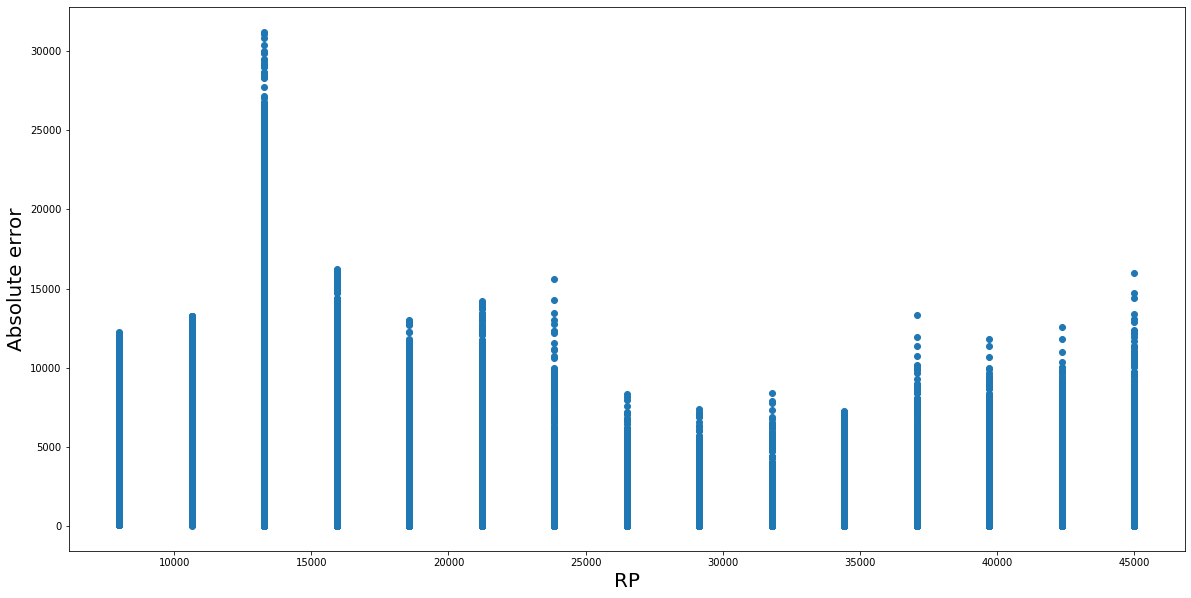

In [89]:
fig, ax = plt.subplots(figsize=(20, 10))
err = np.mean(np.abs(preds[1][target_cols] - df_test_ans[target_cols]), axis=1)
ax.scatter(df['RP'], err)
plt.xlabel("RP", fontsize= 20)
plt.ylabel("Absolute error", fontsize= 20)

# LR + clusterization

In [98]:
# Get cluter id from epoch
df_train['cluster_id'] = pd.to_datetime(df_train.epoch).apply(lambda x: x.time().hour)
df_test['cluster_id'] = pd.to_datetime(df_test.epoch).apply(lambda x: x.time().hour)

In [12]:
# NO Duplicates!
df_train.shape, df_train[['sat_id', 'epoch']].drop_duplicates().shape

((335147, 15), (335147, 2))

In [13]:
# Invalid pairs (test without train)
sizes_train, sizes_test = [], []
invalid = []
zeros = []
for i in range(24):
    for j in tqdm(range(600)):
        size_train = df_train[(df_train.cluster_id == i) & (df_train.sat_id == j)].shape[0]
        size_test = df_test[(df_test.cluster_id == i) & (df_test.sat_id == j)].shape[0]
        sizes_train.append(size_train)
        sizes_test.append(size_test)
        if size_train == 0:
            if size_test == 0:
                zeros.append((i, j))
            else:
                invalid.append((i, j))

100%|██████████| 600/600 [00:04<00:00, 131.52it/s]


In [14]:
print(pd.Series(sizes_train).describe())
pd.Series(sizes_test).describe()

count    14400.000000
mean        23.274097
std         14.389971
min          0.000000
25%         12.000000
50%         21.000000
75%         31.000000
max         93.000000
dtype: float64


count    14400.000000
mean        21.004028
std         12.993723
min          0.000000
25%         11.000000
50%         19.000000
75%         28.000000
max         84.000000
dtype: float64

In [15]:
len(zeros), len(invalid)

(99, 73)

In [97]:
from collections import defaultdict
from copy import deepcopy


def predict_lr_cluster(model, threshold=1, transformer=None):
    cluster_masks_train = list(map(lambda i: df_train.cluster_id == i, range(24)))
    cluster_masks_test = list(map(lambda i: df_test.cluster_id == i, range(24)))

    X_train = df_train[feature_cols + ['cluster_id']].values
    y_train = df_train[target_cols].values
    X_test = df_test[feature_cols + ['cluster_id']].values
    pred = pd.DataFrame(columns=target_cols, index=df_test.index)
    pred["sat_id"] = df_test["sat_id"]
    models_per_cluster = defaultdict(list)

    if transformer:
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.fit_transform(X_test)
    
    for sat_id in tqdm(range(n_sat), position=0, leave=True):
        train_idxs = df_train["sat_id"] == sat_id
        test_idxs = df_test["sat_id"] == sat_id
        for i in range(24):
            mask_train = train_idxs & cluster_masks_train[i]
            if mask_train.sum() >= threshold:
                mask_test = test_idxs & cluster_masks_test[i]
                model.fit(X_train[mask_train], y_train[mask_train])
                models_per_cluster[i].append(deepcopy(model))
                if mask_test.sum():
                    tmp = model.predict(X_test[mask_test])
                    pred.loc[mask_test, target_cols] = tmp
    
    empty = ~pred.notna().all(axis=1)
    for i in tqdm(range(24), position=0, leave=True):
        mask = empty & cluster_masks_test[i]
        if mask.sum():
            bootstrap = list(map(lambda m: m.predict(X_test[mask]), models_per_cluster[i]))
            pred.loc[mask, target_cols] = np.vstack(bootstrap).mean()
    return pred

In [17]:
for model, transformer, i in product(MODELS, TRANSFORMERS, range(1, 21, 4)):
    pred = predict_lr_cluster(MODELS[model], i, TRANSFORMERS[transformer])
    print_metrics(f'{model}, {transformer}, {i} threshold', pred)

100%|██████████| 24/24 [00:10<00:00,  2.19it/s]



LR, No transforms, 1 threshold

IDAO score:  90.68509099399826
SMAPE IDAO:  0.09314909006001736
SMAPE new:   0.17685442240023336


100%|██████████| 24/24 [00:13<00:00,  1.84it/s]



LR, No transforms, 5 threshold

IDAO score:  90.47590936540746
SMAPE IDAO:  0.09524090634592544
SMAPE new:   0.19535220098974349


  4%|▍         | 26/600 [00:38<14:29,  1.51s/it]

KeyboardInterrupt: 

In [18]:
threshold=1
for model, transformer in product(MODELS, TRANSFORMERS):
    pred = predict_lr_cluster(MODELS[model], threshold, TRANSFORMERS[transformer])
    print_metrics(f'{model}, {transformer}, {threshold} threshold', pred)

100%|██████████| 24/24 [00:13<00:00,  1.84it/s]



LR, No transforms, 1 threshold

IDAO score:  90.68509099399826
SMAPE IDAO:  0.09314909006001736
SMAPE new:   0.17685442240023336


100%|██████████| 24/24 [00:11<00:00,  2.10it/s]



LR, Poly, 1 threshold

IDAO score:  89.499581040331
SMAPE IDAO:  0.10500418959669015
SMAPE new:   0.21938073519438936


100%|██████████| 24/24 [00:11<00:00,  2.15it/s]



L2, No transforms, 1 threshold

IDAO score:  75.71831224469724
SMAPE IDAO:  0.24281687755302744
SMAPE new:   0.40058709310225643


100%|██████████| 24/24 [00:11<00:00,  2.08it/s]



L2, Poly, 1 threshold

IDAO score:  81.20915697154362
SMAPE IDAO:  0.18790843028456375
SMAPE new:   0.31777516423948915


100%|██████████| 24/24 [00:11<00:00,  2.11it/s]



L1, No transforms, 1 threshold

IDAO score:  84.07220774543082
SMAPE IDAO:  0.15927792254569184
SMAPE new:   0.2669391728561082


100%|██████████| 24/24 [00:11<00:00,  2.06it/s]



L1, Poly, 1 threshold

IDAO score:  88.07316184381499
SMAPE IDAO:  0.1192683815618502
SMAPE new:   0.19838296428574898


In [100]:
model = MODELS["LR"]
transformer = TRANSFORMERS['No transforms']
pred = predict_lr_cluster(model, 1, transformer)

100%|██████████| 24/24 [00:00<00:00, 1094.43it/s]


Text(0, 0.5, 'Absolute error')

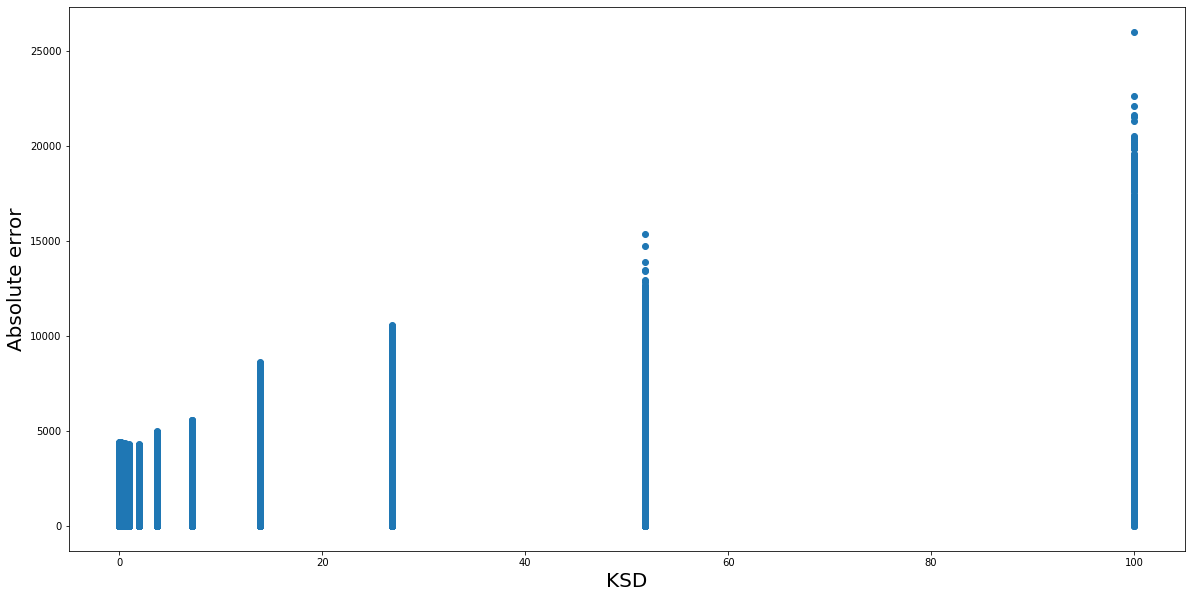

In [102]:
fig, ax = plt.subplots(figsize=(20, 10))
err = np.mean(np.abs(pred[target_cols] - df_test_ans[target_cols]), axis=1)
ax.scatter(df['KSD'], err)
plt.xlabel("KSD", fontsize= 20)
plt.ylabel("Absolute error", fontsize= 20)

Text(0, 0.5, 'Absolute error')

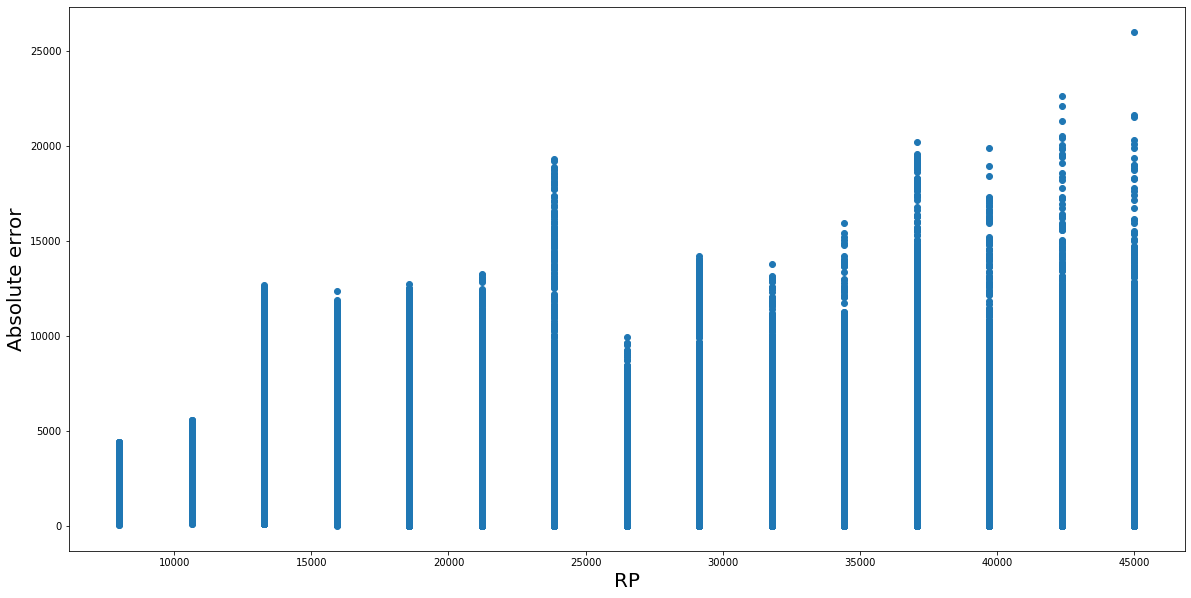

In [104]:
fig, ax = plt.subplots(figsize=(20, 10))
err = np.mean(np.abs(pred[target_cols] - df_test_ans[target_cols]), axis=1)
ax.scatter(df['RP'], err)
plt.xlabel("RP", fontsize= 20)
plt.ylabel("Absolute error", fontsize= 20)

# clusterization only

In [107]:
df_train['cluster_id'] = pd.to_datetime(df_train.epoch).apply(lambda x: x.time().hour)
df_test['cluster_id'] = pd.to_datetime(df_test.epoch).apply(lambda x: x.time().hour)

In [106]:
def predict_cluster(model, transformer=None):
    pred = pd.DataFrame(columns=target_cols, index=df_test.index)
    pred["sat_id"] = df_test["sat_id"]
    
    cluster_masks_train = list(map(lambda i: df_train.cluster_id == i, range(24)))
    cluster_masks_test = list(map(lambda i: df_test.cluster_id == i, range(24)))
    
    X_train = df_train[feature_cols + ['cluster_id']].values
    y_train = df_train[target_cols].values
    X_test = df_test[feature_cols + ['cluster_id']].values
    
    if transformer:
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.fit_transform(X_test)
    
    for i in range(24):
        mask_train = cluster_masks_train[i]
        mask_test = cluster_masks_test[i]
        model = model.fit(X_train[mask_train], y_train[mask_train])
        tmp = model.predict(X_test[mask_test])
        pred.loc[mask_test, target_cols] = tmp
    return pred

In [21]:
for model, transformer in product(list(MODELS.keys())[:-1], TRANSFORMERS):
    pred = predict_cluster(MODELS[model], TRANSFORMERS[transformer])
    print_metrics(f'{model} {transformer}', pred)


LR No transforms

IDAO score:  85.08089899912399
SMAPE IDAO:  0.1491910100087601
SMAPE new:   0.2289816053611771

LR Poly

IDAO score:  81.56397424523415
SMAPE IDAO:  0.18436025754765853
SMAPE new:   0.2750424383622044

L2 No transforms

IDAO score:  60.18300719923963
SMAPE IDAO:  0.39816992800760365
SMAPE new:   0.7624804630062105

L2 Poly

IDAO score:  70.62286040892516
SMAPE IDAO:  0.2937713959107484
SMAPE new:   0.5371839256026474


In [108]:
model = MODELS["LR"]
transformer = TRANSFORMERS['No transforms']
pred = predict_cluster(model, transformer)

Text(0, 0.5, 'Absolute error')

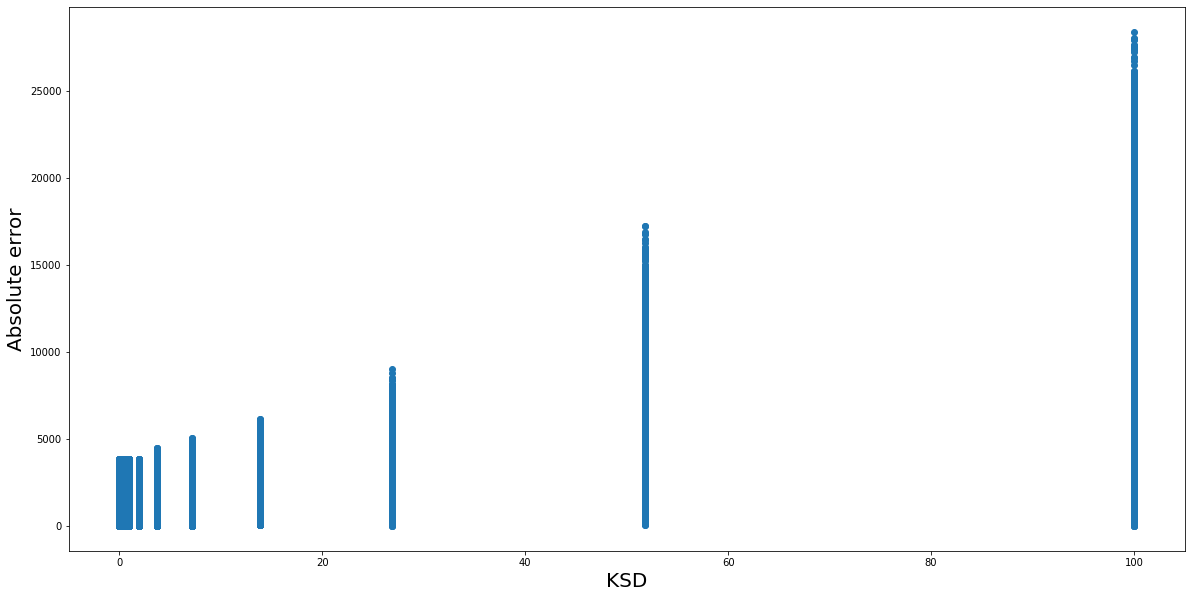

In [109]:
fig, ax = plt.subplots(figsize=(20, 10))
err = np.mean(np.abs(pred[target_cols] - df_test_ans[target_cols]), axis=1)
ax.scatter(df['KSD'], err)
plt.xlabel("KSD", fontsize= 20)
plt.ylabel("Absolute error", fontsize= 20)

Text(0, 0.5, 'Absolute error')

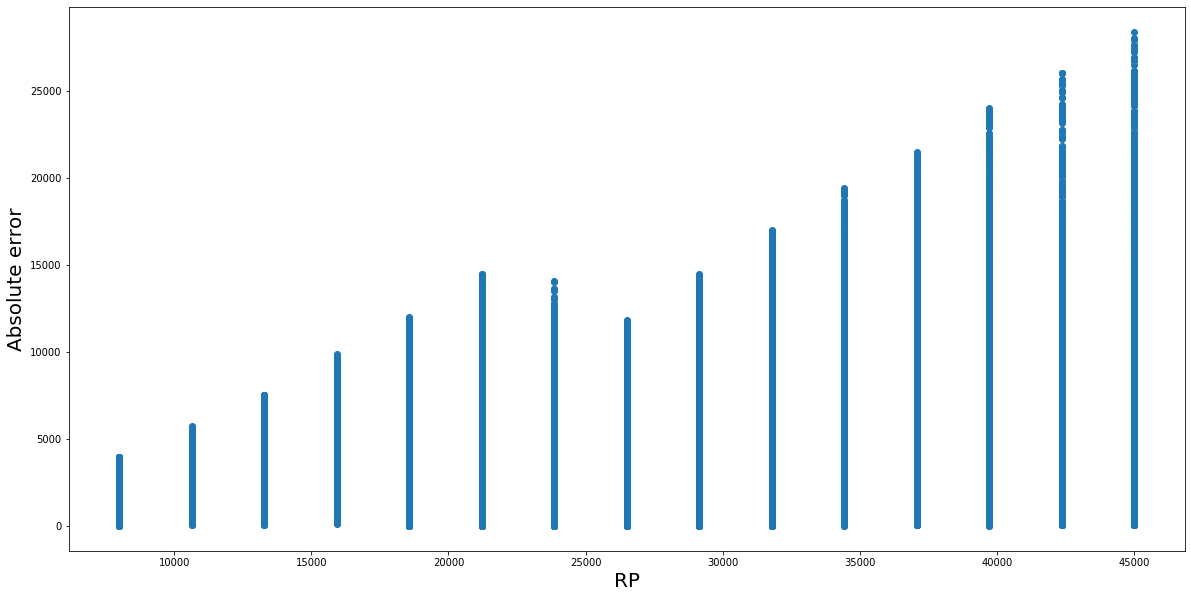

In [110]:
fig, ax = plt.subplots(figsize=(20, 10))
err = np.mean(np.abs(pred[target_cols] - df_test_ans[target_cols]), axis=1)
ax.scatter(df['RP'], err)
plt.xlabel("RP", fontsize= 20)
plt.ylabel("Absolute error", fontsize= 20)

Теперь посчитаем разброс ошибки нашей лучшей модели.

In [145]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    bias, variance, error = None, None, None
    n_obj = X.shape[0]
    idx = np.arange(n_obj)
    idx_b = np.random.choice(idx, (num_runs, n_obj), replace=True)
    X_b, y_b = X[idx_b], y[idx_b]
    oob_mask = np.zeros((num_runs, n_obj))
    oob_real = np.zeros((num_runs, n_obj, 6))
    oob_pred = np.zeros((num_runs, n_obj, 6))
    for i in range(num_runs):
        idx_oob = np.isin(idx, idx_b[i], invert=True)
        oob_mask[i] = idx_oob
        X_oob = X[idx_oob]
        regressor.fit(X_b[i], y_b[i])
        oob_real[i][idx_oob] = y[idx_oob]
        oob_pred[i][idx_oob] = regressor.predict(X_oob)

    pred_counts = oob_mask.sum(axis=0)[:, None]
    average_pred = oob_pred.sum(axis=0) / pred_counts
    
    bias = ((y - average_pred) ** 2).mean(axis=0)
    variance = ((((oob_pred - average_pred) * oob_mask[:, :, None]) ** 2).sum(axis=0) / (pred_counts - 1)).mean(axis=0)
    error = (((oob_pred - oob_real) ** 2).sum(axis=0)[:, None] / pred_counts).mean(axis=0)
    return bias, variance, error

In [146]:
# Linear (Polynomial) Regression models
def predict_lr(model, transformer=None):
    X_train = df_train[feature_cols].values
    y_train = df_train[target_cols].values
    X_test = df_test[feature_cols].values
    pred = pd.DataFrame(columns=target_cols, index=df_test.index)
    pred["sat_id"] = df_test["sat_id"]
    n_sat = len(df_train['sat_id'].unique())
    if transformer:
        X_train = transformer.fit_transform(X_train)
        X_test = transformer.fit_transform(X_test)
    
    for sat_id in range(n_sat): 
        mask_train = df_train.sat_id == sat_id
        mask_test = df_test.sat_id == sat_id
        model.fit(X_train[mask_train], y_train[mask_train]) 
        pred.loc[mask_test, target_cols] = model.predict(X_test[mask_test])
    return pred

### Получение разброса на лучшей модели

In [147]:
model = MODELS['LR']
transformer = TRANSFORMERS['Poly']
X_train = df_train[feature_cols].values
y_train = df_train[target_cols].values
X_test = df_test[feature_cols].values
pred = pd.DataFrame(columns=target_cols, index=df_test.index)
pred["sat_id"] = df_test["sat_id"]
n_sat = len(df_train['sat_id'].unique())
if transformer:
    X_train = transformer.fit_transform(X_train)
    X_test = transformer.fit_transform(X_test)
var = []   
for sat_id in tqdm(range(n_sat)): 
    mask_train = df_train.sat_id == sat_id
    mask_test = df_test.sat_id == sat_id
    var.append(compute_biase_variance(model, X_train[mask_train], y_train[mask_train], num_runs=50))
#     model.fit(X_train[mask_train], y_train[mask_train]) 
#     pred.loc[mask_test, target_cols] = model.predict(X_test[mask_test])

100%|██████████| 225/225 [02:15<00:00,  1.66it/s]


In [150]:
(np.array(var)).shape

(225, 3)

In [151]:
a = np.array(var)[:, 1]

In [152]:
a.mean()

array([6.28577856e+04, 1.00541777e+05, 7.28148596e+02, 6.72654633e-03,
       5.31696721e-03, 9.71006063e-06])

In [159]:
a.mean().mean()

27354.620527032064

In [161]:
b=[]
for i in a:
    b.append(i.mean())
b = np.array(b)

In [162]:
b.mean()

27354.620527032068

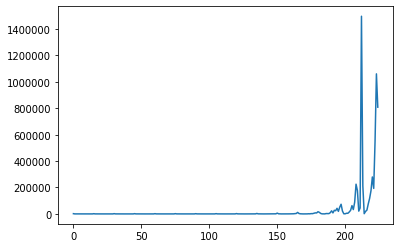

In [163]:
plt.plot(b)